# Klasteryzacja

## Konfiguracja

Użyjemy standardowych bibliotek oraz dodatkowo:
- Plotly - do wizualizacji
- UMAP - redukcja wymiarowości

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn

sklearn.set_config(transform_output="pandas")

## Analiza muzyki ze Spotify

Spotify w swoim API oferuje automatyczną [ekstrakcję cech z piosenek](https://developer.spotify.com/documentation/web-api/reference/get-audio-features), których można następnie użyć do wielu ciekawych analiz, jak np. [tutaj](https://rpubs.com/PeterDola/SpotifyTracks) lub [tutaj](https://rstudio-pubs-static.s3.amazonaws.com/604869_8399a2cf0e4a419da6272452c3d6a6d3.html). Datasetów jest wiele, z czego jednym z największych [jest dostępny tutaj na Kaggle](https://www.kaggle.com/datasets/yamaerenay/spotify-dataset-19212020-600k-tracks?select=tracks.csv) i zawiera ponad 600 tysięcy piosenek.

Cechy zwracane przez API to m. in. akustyczność, taneczność, energia, głośność czy długość piosenki. Pełna lista cech jest dostępna [w dokumentacji](https://developer.spotify.com/documentation/web-api/reference/get-audio-features). Są to bardzo dobre cechy do uczenia maszynowego - niewielka wymiarowość i tylko numeryczne. Wadą jest pewna dość mocna korelacja w niektórych podgatunkach muzycznych, ale akurat to w przypadku klasteryzacji takich danych jest całkiem ok, i może prowadzić do sensownych wniosków.

Spotify definiuje i wykorzystuje ponad 125 gatunków muzycznych, które na dodatek są dość dyskusyjne i płynne. Przykładowo, według różnych klasyfikacji Powerwolf, Ensiferum i Alestorm mogą wylądować w tym samym worku, pomimo zdecydowanie różnej muzyki. Klasteryzacja pozwala tworzyć "płynne" tagi, klasyfikując muzykę w dużo bardziej zniuansowany sposób.

**Uwaga:** zgodnie z licencją API danych nie można używać do treningu modeli ML. Oczywiście tego typu licencje nie dotyczą użytku prywatnego ani zastosowań naukowych, co wynika z ogólnych przepisów. Należy jednak pamiętać, że takich modeli nie wolno w żaden sposób publikować ani wykorzystywać komercyjnie.

**Zadanie 1 (2.5 punktu)**

1. Ściągnij pliki `artists.csv` oraz `tracks.csv` z Kaggle'a.
2. Załaduj pliki `artists.csv` i `tracks.csv` do zmiennych `df_artists` i `df_tracks`.
3. Usuń wiersze z wartościami brakującymi z obu ramek danych.
4. Ponad 600 tysięcy piosenek to zdecydowanie za dużo, a na dodatek przeważająca większość z nich to drobni, mało znani artyści. Aby to zweryfikować, narysuj histogramy popularności artystów oraz piosenek. Użyj 100 kubełków (bins). Pamiętaj o tytułach wykresów.
5. Dokonaj filtrowania:
   - pozostaw artystów z popularnością >= 55
   - pozostaw piosenki z popularnością >= 55
   - usuń piosenki trwające powyżej 600000 ms (10 minut)
   - użyj funkcji `remove_weird_genres()`, żeby usunąć piosenki z ekstremalnie rzadkich gatunków muzycznych
   - użyj funkcji `filter_english_only()`, aby pozostawić tylko anglojęzyczne tytuły
6. Użyj podanej funkcji `extract_artist_id()` na ramce z piosenkami, która dodaje kolumnę `main_artist_id`.
7. Połącz ramki w jedną, `df_songs`, z wszystkimi informacjami:
   - użyj kolumn `main_artist_id` (ramka z piosenkami) oraz `id` (ramka z artystami)
   - przyda się `pd.merge()`
   - Pandas automatycznie dodaje sufiksy do kolumn (argument `suffixes`), żeby rozróżnić kolumny po takiej operacji JOIN
   - domyślnie są to mało znaczące `_x` i `_y`, zmień je na `_track` i `_artist`
8. Usuń duplikaty wedle kolumn `name_track` oraz `name_artist`.
9. Mamy kolumny z danymi, które identyfikują piosenki: nazwa piosenki, artysta, gatunki muzyczne. Nie są one jednak użyteczne do samej klasteryzacji. Wyodrębnij je do osobnej ramki `df_songs_info`.
```
songs_info_cols = [
    "name_track",
    "name_artist",
    "genres"
]
```
10. Stwórz nową ramkę `df_songs_features`, pozostawiając tylko kolumny z cechami do klasteryzacji:
```
songs_features_cols = [
    "explicit",
    "loudness",
    "mode",
    "speechiness",
    "acousticness",
    "instrumentalness",
    "liveness",
    "valence",
    "tempo",
]
```
11. Wypisz finalną liczbę piosenek (rozmiar zbioru).

**Uwaga:** jeżeli notebook będzie wykonywał się zbyt długo, to można ustawić wyższy próg popularności, żeby uzyskać mniejszy podzbiór najbardziej popularnych piosenek.

In [14]:
import ast
from fast_langdetect import detect as detect_language


def extract_artist_id(df_tracks: pd.DataFrame) -> pd.DataFrame:
    df_tracks["main_artist_id"] = df_tracks["id_artists"].apply(
        lambda x: ast.literal_eval(x)[0]
    )
    return df_tracks


def remove_weird_genres(df_artists: pd.DataFrame) -> pd.DataFrame:
    all_genres = []
    for song_genres in df_artists["genres"]:
        all_genres.extend(ast.literal_eval(song_genres))

    df_genres = pd.Series(all_genres).value_counts().reset_index()

    weird_genres = df_genres.loc[df_genres["count"] < 150, "index"]
    weird_genres = set(weird_genres.tolist())

    to_keep = []
    for song_genres in df_artists["genres"]:
        song_genres = set(ast.literal_eval(song_genres))
        not_all_weird = len(song_genres - weird_genres) > 0
        to_keep.append(not_all_weird)

    df_artists = df_artists[to_keep]
    return df_artists


def filter_english_only(df_tracks: pd.DataFrame) -> pd.DataFrame:
    english = [
        detect_language(title[:100], low_memory=False)["lang"] == "en"
        for title in df_tracks["name"]
    ]
    return df_tracks[english]

Artists after removing NaN: 1162081
Tracks after removing NaN: 586601


Text(0, 0.5, 'Count')

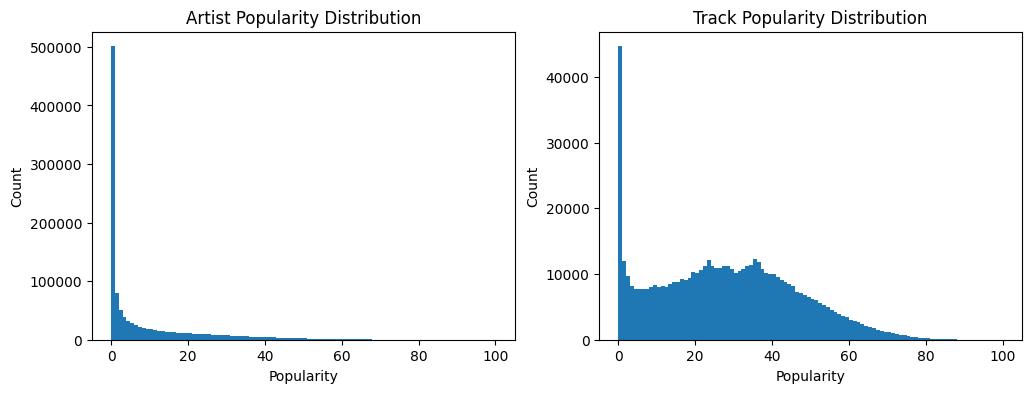

In [25]:
df_artists = pd.read_csv("artists.csv")
df_tracks = pd.read_csv("tracks.csv")

df_artists = df_artists.dropna()
df_tracks = df_tracks.dropna()

print(f"Artists after removing NaN: {len(df_artists)}")
print(f"Tracks after removing NaN: {len(df_tracks)}")

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(df_artists["popularity"], bins=100)
plt.title("Artist Popularity Distribution")
plt.xlabel("Popularity")
plt.ylabel("Count")

plt.subplot(1, 2, 2)
plt.hist(df_tracks["popularity"], bins=100)
plt.title("Track Popularity Distribution")
plt.xlabel("Popularity")
plt.ylabel("Count")

In [28]:
df_artists_filtered = df_artists[df_artists["popularity"] >= 60]
print(f"Artists with popularity >= 60: {len(df_artists_filtered)}")

df_tracks_filtered = df_tracks[df_tracks["popularity"] >= 60]
print(f"Tracks with popularity >= 60: {len(df_tracks_filtered)}")

df_tracks_filtered = df_tracks_filtered[df_tracks_filtered["duration_ms"] <= 600000]
print(f"Tracks after removing long ones (>10 min): {len(df_tracks_filtered)}")

df_artists_filtered = remove_weird_genres(df_artists_filtered)
print(f"Artists after removing weird genres: {len(df_artists_filtered)}")

df_tracks_filtered = filter_english_only(df_tracks_filtered)
print(f"Tracks after English filter: {len(df_tracks_filtered)}")

Artists with popularity >= 60: 7589
Tracks with popularity >= 60: 27844
Tracks after removing long ones (>10 min): 27812
Artists after removing weird genres: 2798
Tracks after English filter: 17806


In [29]:
df_tracks_filtered = extract_artist_id(df_tracks_filtered)
df_songs = pd.merge(
    df_tracks_filtered,
    df_artists_filtered,
    left_on="main_artist_id",
    right_on="id",
    suffixes=("_track", "_artist"),
)

df_songs.columns

Index(['id_track', 'name_track', 'popularity_track', 'duration_ms', 'explicit',
       'artists', 'id_artists', 'release_date', 'danceability', 'energy',
       'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature',
       'main_artist_id', 'id_artist', 'followers', 'genres', 'name_artist',
       'popularity_artist'],
      dtype='object')

In [30]:
df_songs = df_songs.drop_duplicates(subset=["name_track", "name_artist"])

In [31]:
songs_info_cols = ["name_track", "name_artist", "genres"]

songs_features_cols = [
    "explicit",
    "loudness",
    "mode",
    "speechiness",
    "acousticness",
    "instrumentalness",
    "liveness",
    "valence",
    "tempo",
]

df_songs_info = df_songs[songs_info_cols]
df_songs_features = df_songs[songs_features_cols]

print(f"Songs info shape: {df_songs_info.shape}")
print(f"Songs features shape: {df_songs_features.shape}")

Songs info shape: (9087, 3)
Songs features shape: (9087, 9)


Mamy teraz przygotowane dane, więc można brać się za klasteryzację. Nasz zbiór jest dość duży, nawet po dokonanym ostrym filtrowaniu, więc potrzebujemy skalowalnych algorytmów klasteryzacji. Klasteryzacja hierarchiczna zdecydowanie odpada, pozostają więc k-means, DBSCAN i HDBSCAN. Co prawda hiperparametry do DBSCAN ciężko jest dobrać, ale zobaczymy, jak można to zrobić.

Zanim przejdziemy do klasteryzacji, trzeba ustandardyzować nasze dane. Po tym trzeba przeprowadzić też globalną analizę naszego zbioru, jak na przykład rozkłady cech, albo zwizualizować go z pomocą redukcji wymiaru. Jest to ważne, bo przy późniejszej analizie klastrów musimy wiedzieć, czy klastry w ogóle różnią się od ogółu naszych danych.

**Zadanie 2 (1 punkt)**

1. Dokonaj standaryzacji cech, tworząc ramkę `X`.
2. Uzupełnij kod klasy `ClusteringVisualizer`, która przyjmuje dane, numery klastrów dla poszczególnych punktów (opcjonalne), i przedstawia wykresy PCA oraz UMAP:
   - zredukuj dane do 2 wymiarów
   - pamiętaj o `random_state=0`
   - [dokumentacja UMAP](https://umap-learn.readthedocs.io/en/latest/basic_usage.html)
   - przekaż `low_memory=False` dla UMAP
   - ze względu na specyfikę implementacji, wykorzystanie `.fit_transform()` będzie zauważalnie szybsze od osobnych `.fit()` i `.transform()`
   - skomentuj:
     - czy w przypadkU PCA widać jakąś strukurę klastrów?
     - czy widać ją w przypadku UMAP?
     - czy redukcja nieliniowa dała lepsze, czy gorsze wyniki od liniowego PCA w wizualizacji?

Czemu klasa, a nie funkcja? UMAP, jak praktycznie wszystkie metody nieliniowej redukcji wymiaru, wykorzystuje graf najbliższych sąsiadów. Jeżeli obliczymy dane po redukcji raz, i zapiszemy jako atrybut, to później będziemy mogli uniknąć liczenia tego wielokrotnie. Zapisanie tych wyników zaoszczędzi nam wiele minut :)

In [33]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X = scaler.fit_transform(df_songs_features)

In [36]:
from typing import Optional

from IPython.display import display
from sklearn.decomposition import PCA
from umap.umap_ import UMAP


class ClusteringVisualizer:
    def __init__(self, X: np.ndarray | pd.DataFrame):
        # PCA
        pca = PCA(n_components=2, random_state=0)
        self.X_pca = pca.fit_transform(X)

        # UMAP
        umap = UMAP(n_components=2, random_state=0, low_memory=False)
        self.X_umap = umap.fit_transform(X)

    def visualize(self, labels: Optional[np.ndarray] = None):
        if labels is None:
            labels = np.ones(len(X))

        fig, axes = plt.subplots(1, 2, figsize=(9, 3))

        pca_data = (
            self.X_pca if isinstance(self.X_pca, np.ndarray) else self.X_pca.values
        )
        axes[0].scatter(pca_data[:, 0], pca_data[:, 1], c=labels, alpha=0.6)
        axes[0].set_title("PCA")
        axes[0].set_xlabel("PC1")
        axes[0].set_ylabel("PC2")

        umap_data = (
            self.X_umap if isinstance(self.X_umap, np.ndarray) else self.X_umap.values
        )
        axes[1].scatter(umap_data[:, 0], umap_data[:, 1], c=labels, alpha=0.6)
        axes[1].set_title("UMAP")
        axes[1].set_xlabel("UMAP1")
        axes[1].set_ylabel("UMAP2")

        fig.suptitle("Clustering visualization")
        plt.show()

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


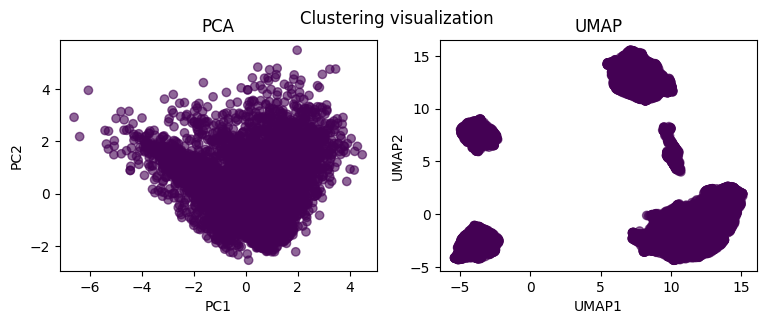

In [37]:
clustering_visualizer = ClusteringVisualizer(X)
clustering_visualizer.visualize()

**PCA:** Nie widać wyraźnej struktury klastrów - dane tworzą jedną dużą, zwartą chmurę punktów bez widocznych separacji czy podgrup.

**UMAP:** Wyraźnie widać strukturę klastrową - dane rozdzieliły się na 5 odrębnych grup o różnych kształtach i wielkościach.

Redukcja nieliniowa (UMAP) dała zdecydowanie lepsze wyniki w wizualizacji struktury danych. Podczas gdy PCA pokazuje tylko jedną chmurę, UMAP ujawnia ukrytą strukturę klastrową, co sugeruje, że dane mają nieliniowe zależności.

Teraz przeanalizujemy nasz zbiór. Posłużą nam do tego poniżej zdefiniowane klasy `KMeansAnalzyer`, `DBSCANAnalyzer` i `HDBSCANAnalyzer`. Metoda `.analyze_clustering()` dla każdego klastra:
1. Wypisuje liczbę klastrów, oraz informację o szumie (dla DBSCAN i HDBSCAN).
2. Wypisuje wartość metryki [Calinski-Harabasz index](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.calinski_harabasz_score.html), jeżeli liczba klastrów to co najmniej 2. Dla DBSCAN i HDBSCAN uwzględniamy tylko punkty z klastrów, ignorując szum.
2. Rysuje wykres klastrów po redukcji z PCA oraz UMAP.
3. Tworzy [wykres radowy (radar chart)](https://plotly.com/python/radar-chart/). Pozwala on wygodnie porównać wartości średnie dla poszczególnych cech.
4. Wypisuje piosenki i artystów reprezentujące klaster:
   - dla k-means jest to 10 punktów najbliższych do centroidu
   - dla DBSCAN wybieramy heurystycznie 10 punktów najbliższych do centroidu
   - dla HDBSCAN wybieramy punkty o najwyższym prawdopodobieństwie (nie używamy exemplars, bo jest to bardzo wolne [i mało wygodne](https://github.com/scikit-learn-contrib/hdbscan/issues/304))
5. Wypisuje 10 najczęstszych gatunków muzycznych w klastrze.

Dla DBSCAN i HDBSCAN, które same wykrywają liczbę klastrów i może być ich bardzo dużo, analizowane jest tylko:
- max 10 największych klastrów
- tylko te, które mają co najmniej 100 próbek

Na początek potraktujemy cały nasz zbiór jako jeden wielki klaster dla algorytmu k-means i popatrzymy, co tam się dzieje.

In [38]:
import itertools
from abc import ABC, abstractmethod
from collections import Counter

import plotly.graph_objects as go

from sklearn.cluster import DBSCAN, HDBSCAN, KMeans
from sklearn.metrics import calinski_harabasz_score
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import minmax_scale


class ClusteringAnalyzer(ABC):
    def __init__(
        self, df_songs_info: pd.DataFrame, clustering_visualizer: ClusteringVisualizer
    ):
        self.df_songs_info = df_songs_info
        self.clustering_visualizer = clustering_visualizer

    @abstractmethod
    def analyze_clustering(self, X: pd.DataFrame, clustering) -> None:
        raise NotImplementedError()

    def _get_top_clusters_labels(self, labels: np.ndarray) -> np.ndarray:
        labels = labels[labels != -1]
        label_counts = pd.Series(labels).value_counts()
        label_counts = label_counts[label_counts >= 100]
        top_labels = label_counts.index[:10].values
        return top_labels

    def _create_radar_chart(self, X: pd.DataFrame, label: int) -> None:
        fig = go.Figure()
        vals = minmax_scale(X).mean()
        fig.add_trace(go.Scatterpolar(r=vals, theta=X.columns, fill="toself"))
        fig.update_layout(title_text=f"Cluster {label}", title_x=0.5)
        fig.update_polars(radialaxis=dict(range=[0, 1]))
        fig.show()

    def _get_central_songs(
        self, X: pd.DataFrame, cluster_songs_info: pd.DataFrame, prototype: np.ndarray
    ) -> None:
        n_neighbors = min(10, len(X))
        nn = NearestNeighbors(n_neighbors=n_neighbors, n_jobs=-1)
        nn.fit(X.values)
        _, nn_idxs = nn.kneighbors(prototype)
        nn_idxs = nn_idxs.ravel()
        nn_songs_info = cluster_songs_info.iloc[nn_idxs]
        nn_songs_info = nn_songs_info.drop(columns="genres")
        nn_songs_info.columns = ["Track", "Artist"]
        nn_songs_info = nn_songs_info.reset_index(drop=True)
        display(nn_songs_info)

    def _get_cluster_top_genres(
        self,
        cluster_songs_info: pd.DataFrame,
    ) -> None:
        genres = cluster_songs_info["genres"].values
        genres = [ast.literal_eval(x) for x in genres]
        genres = Counter(itertools.chain(*genres))
        top_genres = genres.most_common(10)
        top_genres = [name for name, count in top_genres]
        print("Top 10 genres in the cluster:", top_genres)


class KMeansAnalyzer(ClusteringAnalyzer):
    def analyze_clustering(self, X: pd.DataFrame, clustering: KMeans) -> None:
        labels = clustering.labels_
        centroids = clustering.cluster_centers_

        print(f"Number of clusters: {max(labels) + 1}")

        if labels.max() >= 2:
            ch_index = calinski_harabasz_score(X, labels)
            print(f"CH-index value: {ch_index:.2f}")

        self.clustering_visualizer.visualize(labels)

        for label in range(0, max(labels) + 1):
            X_cluster = X[labels == label]
            cluster_songs_info = df_songs_info[labels == label]
            centroid = centroids[label].reshape((1, -1))

            print(f"Cluster {label} size: {len(X_cluster)}")
            self._create_radar_chart(X_cluster, label)
            self._get_central_songs(X_cluster, cluster_songs_info, centroid)
            self._get_cluster_top_genres(cluster_songs_info)


class DBSCANAnalyzer(ClusteringAnalyzer):
    def analyze_clustering(self, X: pd.DataFrame, clustering: DBSCAN) -> None:
        labels = clustering.labels_

        noise_num = (labels == -1).sum()
        noise_perc = noise_num / len(X)

        print(f"Number of clusters: {max(labels) + 1}")
        print(f"Percentage of noise points: {100 * noise_perc:.2f}%")

        if labels.max() >= 2:
            X_non_noise = X[labels != -1]
            labels_non_noise = labels[labels != -1]
            ch_index = calinski_harabasz_score(
                X_non_noise,
                labels_non_noise,
            )
            print(f"CH-index value: {ch_index:.2f}")

        self.clustering_visualizer.visualize(labels)

        for label in self._get_top_clusters_labels(labels):
            X_cluster = X[labels == label]
            cluster_songs_info = df_songs_info[labels == label]
            centroid = self._get_cluster_centroid(X_cluster)

            print(f"Cluster {label} size: {len(X_cluster)}")
            self._create_radar_chart(X_cluster, label)
            self._get_central_songs(X_cluster, cluster_songs_info, centroid)
            self._get_cluster_top_genres(cluster_songs_info)

    def _get_cluster_centroid(self, X_cluster: pd.DataFrame) -> np.ndarray:
        centroid = np.mean(X_cluster.values, axis=0)
        return np.array(centroid).reshape((1, -1))


class HDBSCANAnalyzer(ClusteringAnalyzer):
    def analyze_clustering(self, X: pd.DataFrame, clustering: HDBSCAN) -> None:
        labels = clustering.labels_
        probas = clustering.probabilities_

        noise_num = (labels == -1).sum()
        noise_perc = noise_num / len(X)

        print(f"Number of clusters: {max(labels) + 1}")
        print(f"Percentage of noise points: {100 * noise_perc:.2f}%")

        if labels.max() >= 2:
            X_non_noise = X[labels != -1]
            labels_non_noise = labels[labels != -1]
            ch_index = calinski_harabasz_score(
                X_non_noise,
                labels_non_noise,
            )
            print(f"CH-index value: {ch_index:.2f}")

        self.clustering_visualizer.visualize(labels)

        for label in self._get_top_clusters_labels(labels):
            X_cluster = X[labels == label]
            cluster_songs_info = df_songs_info[labels == label]
            cluster_probas = probas[labels == label]

            print(f"Cluster {label} size: {len(X_cluster)}")
            self._create_radar_chart(X_cluster, label)
            self._get_most_probable_songs(X_cluster, cluster_songs_info, cluster_probas)
            self._get_cluster_top_genres(cluster_songs_info)

    def _get_most_probable_songs(
        self,
        X: pd.DataFrame,
        cluster_songs_info: pd.DataFrame,
        cluster_probas: np.ndarray,
    ) -> None:
        top_10_indexes = np.argpartition(cluster_probas, -10)[-10:]
        nn_songs_info = cluster_songs_info.iloc[top_10_indexes]
        nn_songs_info = nn_songs_info.drop(columns="genres")
        nn_songs_info.columns = ["Track", "Artist"]
        nn_songs_info = nn_songs_info.reset_index(drop=True)
        display(nn_songs_info)

Number of clusters: 1


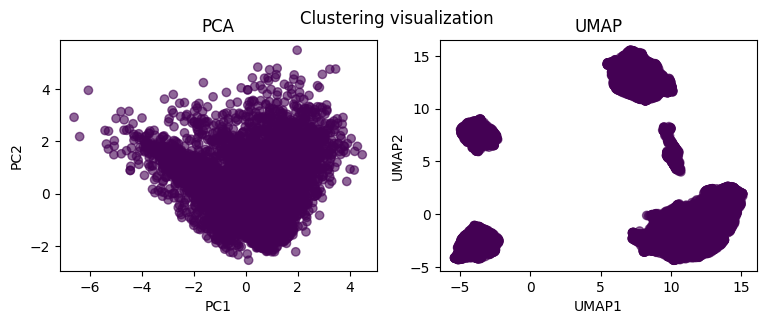

Cluster 0 size: 9087


,Track,Artist
0,Fake ID,Riton
1,Lay It All on Me (feat. Ed Sheeran),Rudimental
2,Rather Be (feat. Jess Glynne),Clean Bandit
3,Happy Now,Kygo
4,TOOTIMETOOTIMETOOTIME,The 1975
5,On The Floor - Radio Edit,Jennifer Lopez
6,I Just Wanna (feat. Bow Anderson),Felix Jaehn
7,Hold On (feat. Cheat Codes) - Radio Edit,Moguai
8,Woke up in Bangkok,Deepend
9,Penny Lane - Remastered 2009,The Beatles


Top 10 genres in the cluster: ['pop', 'dance pop', 'rock', 'post-teen pop', 'rap', 'pop rap', 'hip hop', 'classic rock', 'modern rock', 'pop rock']


In [39]:
from sklearn.cluster import KMeans

clustering = KMeans(n_clusters=1, n_init="auto", random_state=0)
clustering.fit(X)

kmeans_analyzer = KMeansAnalyzer(df_songs_info, clustering_visualizer)
kmeans_analyzer.analyze_clustering(X, clustering)

Wygląda na to, że najpopularniejsze są pop i rock, a najbardziej "typowe" piosenki też należą do takiej grupy. Ogół piosenek ma dość dużą głośność, dużą dynamikę (wysokie time signature - "how many beats are in each bar") i są pozytywne (valence - "tracks with high valence sound more positive"). Zasadniczo jest to zgodne z intuicją. Ciekawe jednak, co będzie, jak wybierzemy więcej klastrów.

**Zadanie 3 (1.5 punktu)**

1. Wytrenuj k-means dla 3 klastrów.
2. Zwizualizuj wyniki za pomocą PCA i UMAP. Jako kolor punktów (np. parametr `c` w `plt.scatter()`) przekaż numery klastrów dla punktów.
3. Dokonaj opisu i analizy wynikowych klastrów, na przykład:
   - czy reprezentują jakieś konkretne grupy muzyczne?
   - na ile "konkretne", sensowne są klastry?
   - czy jest widoczna separacja klastrów, czy różnią się od siebie?
4. Dokonaj tuningu liczby klastrów:
   - sprawdź wartości z zakresu [5, 20] - w końcu wiemy, że gatunków jest sporo, i klastrów powinno też być więcej
   - dla każdej wartości sprawdź wartość metryki [Calinski-Harabasz index](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.calinski_harabasz_score.html)
   - przedstaw wykres liniowy (line plot) wartości metryki
   - wybierz model o najwyższej wartości metryki
   - zwizualizuj wyniki z pomocą PCA i UMAP
   - dokonaj interpretacji jego klastrów
   - skomentuj:
     - czy klastry są faktycznie lepiej interpretowalne po tuningu?
     - czy wysokość CH-index faktycznie odpowiada jakości klasteryzacji?


Number of clusters: 3
CH-index value: 1063.85


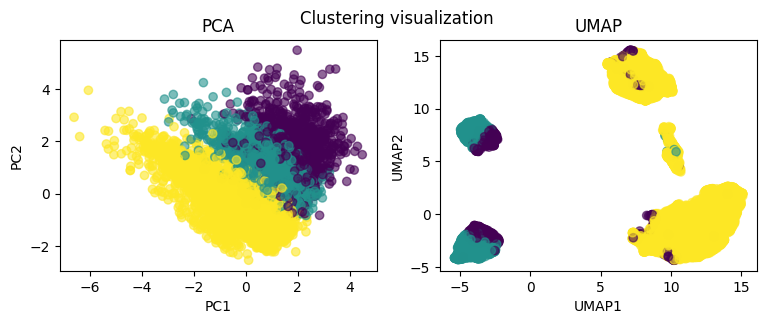

Cluster 0 size: 968


,Track,Artist
0,Russian Cream,Key Glock
1,"34+35 Remix (feat. Doja Cat, Megan Thee Stalli...",Ariana Grande
2,Land Of The Snakes,J. Cole
3,Wesley's Theory,Kendrick Lamar
4,BedRock,Young Money
5,Baby (Lil Baby feat. DaBaby),Quality Control
6,That's Why I Love You (feat. Sabrina Claudio),SiR
7,"SoIcyBoyz 2 (feat. Pooh Shiesty, Foogiano & Ta...",Big Scarr
8,Garden (Say It Like Dat),SZA
9,Twinz (Deep Cover 98) (feat. Fat Joe),Big Pun


Top 10 genres in the cluster: ['rap', 'hip hop', 'pop rap', 'trap', 'pop', 'gangster rap', 'dance pop', 'southern hip hop', 'east coast hip hop', 'hardcore hip hop']
Cluster 1 size: 1492


,Track,Artist
0,Prospect (ft. Lil Baby),iann dior
1,Lalala,Y2K
2,Whenever (feat. Conor Maynard),Kris Kross Amsterdam
3,I'm Just Feelin' (Du Du Du),Imanbek
4,Lying Is the Most Fun a Girl Can Have Without ...,Panic! At The Disco
5,Take Care of You,Ella Henderson
6,Jump Out The Window,Big Sean
7,No Interruption,Hoodie Allen
8,Molly (feat. Brendon Urie of Panic at the Disco),Lil Dicky
9,Broken Clocks,SZA


Top 10 genres in the cluster: ['rap', 'pop rap', 'pop', 'hip hop', 'trap', 'dance pop', 'southern hip hop', 'post-teen pop', 'r&b', 'gangster rap']
Cluster 2 size: 6627


,Track,Artist
0,Lay It All on Me (feat. Ed Sheeran),Rudimental
1,Rather Be (feat. Jess Glynne),Clean Bandit
2,Penny Lane - Remastered 2009,The Beatles
3,Harness Your Hopes - B-side,Pavement
4,Fake ID,Riton
5,I'd Rather,Luther Vandross
6,Cheerleader - Felix Jaehn Remix Radio Edit,OMI
7,Woke up in Bangkok,Deepend
8,Strangers Like Me,Phil Collins
9,I Just Wanna (feat. Bow Anderson),Felix Jaehn


Top 10 genres in the cluster: ['pop', 'rock', 'dance pop', 'post-teen pop', 'classic rock', 'mellow gold', 'pop rock', 'soft rock', 'modern rock', 'album rock']


In [41]:
kmeans_3 = KMeans(n_clusters=3, n_init="auto", random_state=0)
kmeans_3.fit(X)

kmeans_analyzer.analyze_clustering(X, kmeans_3)

Algorytm sztucznie podzielił podobne grupy, a jednocześnie połączył różne gatunki w jeden klaster. K-means zakłada sferyczne klastry o podobnych rozmiarach, co nie pasuje do rzeczywistej struktury danych muzycznych - gatunki tworzą grupy o różnych kształtach i wielkościach. DBSCAN może lepiej poradzić sobie z nierównomiernymi klastrami i wykryć małe, gęste grupy.

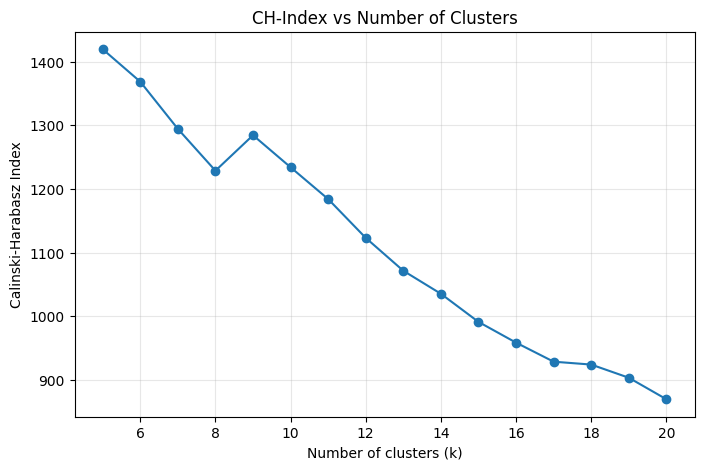

In [44]:
k_values = range(5, 21)
ch_scores = []
kmeans_models = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, n_init="auto", random_state=0)
    kmeans.fit(X)
    labels = kmeans.labels_
    ch_score = calinski_harabasz_score(X, labels)
    ch_scores.append(ch_score)
    kmeans_models.append(kmeans)

plt.figure(figsize=(8, 5))
plt.plot(k_values, ch_scores, marker="o")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Calinski-Harabasz Index")
plt.title("CH-Index vs Number of Clusters")
plt.grid(True, alpha=0.3)

Number of clusters: 5
CH-index value: 1419.51


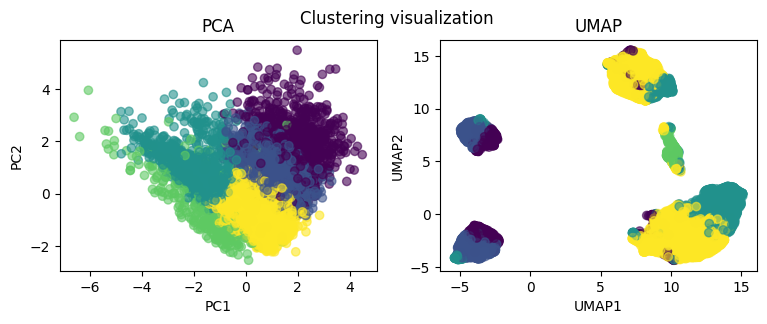

Cluster 0 size: 919


,Track,Artist
0,Russian Cream,Key Glock
1,Land Of The Snakes,J. Cole
2,"34+35 Remix (feat. Doja Cat, Megan Thee Stalli...",Ariana Grande
3,Wesley's Theory,Kendrick Lamar
4,Baby (Lil Baby feat. DaBaby),Quality Control
5,That's Why I Love You (feat. Sabrina Claudio),SiR
6,Twinz (Deep Cover 98) (feat. Fat Joe),Big Pun
7,BedRock,Young Money
8,Garden (Say It Like Dat),SZA
9,"SoIcyBoyz 2 (feat. Pooh Shiesty, Foogiano & Ta...",Big Scarr


Top 10 genres in the cluster: ['rap', 'hip hop', 'pop rap', 'trap', 'gangster rap', 'pop', 'southern hip hop', 'dance pop', 'east coast hip hop', 'hardcore hip hop']
Cluster 1 size: 1396


,Track,Artist
0,Prospect (ft. Lil Baby),iann dior
1,Lying Is the Most Fun a Girl Can Have Without ...,Panic! At The Disco
2,Whenever (feat. Conor Maynard),Kris Kross Amsterdam
3,Jump Out The Window,Big Sean
4,These Walls,Kendrick Lamar
5,Lalala,Y2K
6,Take Care of You,Ella Henderson
7,I'm Just Feelin' (Du Du Du),Imanbek
8,Do What I Want,Lil Uzi Vert
9,Bodak Yellow,Cardi B


Top 10 genres in the cluster: ['rap', 'pop rap', 'hip hop', 'pop', 'trap', 'dance pop', 'southern hip hop', 'post-teen pop', 'gangster rap', 'melodic rap']
Cluster 2 size: 1761


,Track,Artist
0,Frozen,Madonna
1,Tenerife Sea,Ed Sheeran
2,Even the Nights Are Better,Air Supply
3,Changes - 2015 Remaster,David Bowie
4,Nightshift,Commodores
5,Don’t You (Taylor’s Version) (From The Vault),Taylor Swift
6,The Most Beautiful Thing,Bruno Major
7,mirrorball,Taylor Swift
8,The Greatest,Cat Power
9,Time - 2011 Remastered Version,Pink Floyd


Top 10 genres in the cluster: ['pop', 'rock', 'mellow gold', 'classic rock', 'soft rock', 'post-teen pop', 'dance pop', 'folk rock', 'album rock', 'pop rock']
Cluster 3 size: 320


,Track,Artist
0,Talking,Elderbrook
1,House Of Cards,Radiohead
2,Sail,AWOLNATION
3,Cola,CamelPhat
4,Sun Models (feat. Madelyn Grant),ODESZA
5,On My Mind,Diplo
6,Lullaby - Remastered,The Cure
7,Beautiful Girl,INXS
8,Ghostkeeper,Klangkarussell
9,Photograph,Def Leppard


Top 10 genres in the cluster: ['rock', 'alternative rock', 'classic rock', 'permanent wave', 'art rock', 'album rock', 'pop', 'modern rock', 'tropical house', 'edm']
Cluster 4 size: 4691


,Track,Artist
0,Rather Be (feat. Jess Glynne),Clean Bandit
1,All I Am,Jess Glynne
2,Cigarettes out the Window,TV Girl
3,Cheerleader - Felix Jaehn Remix Radio Edit,OMI
4,Broken,Lifehouse
5,We're Good,Dua Lipa
6,Defenceless,Louis Tomlinson
7,Heaven,Avicii
8,Metal Health (Bang Your Head),Quiet Riot
9,Lay It All on Me (feat. Ed Sheeran),Rudimental


Top 10 genres in the cluster: ['pop', 'dance pop', 'rock', 'post-teen pop', 'modern rock', 'pop rock', 'classic rock', 'pop dance', 'edm', 'album rock']


In [45]:
best_k_idx = np.argmax(ch_scores)
best_ch_score = ch_scores[best_k_idx]
kmeans_best = kmeans_models[best_k_idx]
labels_best = kmeans_best.labels_

kmeans_analyzer.analyze_clustering(X, kmeans_best)

Klasteryzacja z k=7 wygląda znacznie lepiej - małe wyspy w UMAP mają teraz własne klastry zamiast być włączone do większych grup. W PCA nadal widać duże nakładanie się klastrów, co potwierdza nieliniową naturę danych muzycznych. Podział lepiej odzwierciedla naturalną strukturę danych, choć największa grupa mogłaby być jeszcze bardziej rozdrobniona.

Problem z k-means jest taki, że wykrywa tylko klastry sferyczne. W przypadku zbiorów, w których klastry mogą być mocno wymieszane, będzie to szczególnym problemem. Tak może być tutaj - w końcu mamy co najmniej kilka podgatunków rocka i popu, które są zbliżone do siebie. Mamy też dość egzotyczne podgatunki takie jak "art rock" czy "rock en espanol", które być może są nieliczne i stanowią de facto szum.

Do takich sytuacji doskonale nadaje się DBSCAN. Ma co prawda większą złożoność, ale dla danych tego rozmiaru jest to jeszcze akceptowalne. Sprawdźmy, jak działa dla domyślnych hiperparametrów - epsilon 0.5 i min_samples 5.

Number of clusters: 65
Percentage of noise points: 74.55%
CH-index value: 51.93


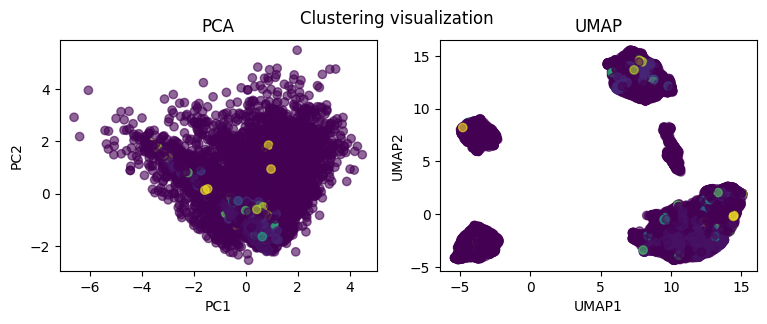

Cluster 2 size: 1355


,Track,Artist
0,Defenceless,Louis Tomlinson
1,Heaven,Avicii
2,Carefully,Demi Lovato
3,Change My Mind,One Direction
4,Nobody,Mitski
5,I Want It All,Lucas & Steve
6,Breakfast At Tiffany's,Deep Blue Something
7,I Wish You Would,Taylor Swift
8,Why Do You Feel So Down,Declan McKenna
9,Baby,Madison Beer


Top 10 genres in the cluster: ['pop', 'dance pop', 'post-teen pop', 'rock', 'pop rock', 'modern rock', 'pop dance', 'classic rock', 'tropical house', 'edm']
Cluster 6 size: 438


,Track,Artist
0,Counting Stars,OneRepublic
1,Ocean Drive,Duke Dumont
2,Love Again,Dua Lipa
3,Sacrifice,Bebe Rexha
4,Come As You Are,Nirvana
5,React,The Pussycat Dolls
6,Fairly Local,Twenty One Pilots
7,Lies,MK
8,A Year Without Rain,Selena Gomez & The Scene
9,We Are One (Ole Ola) [The Official 2014 FIFA W...,Pitbull


Top 10 genres in the cluster: ['pop', 'dance pop', 'post-teen pop', 'pop dance', 'edm', 'tropical house', 'rock', 'modern rock', 'electro house', 'pop rap']
Cluster 4 size: 102


,Track,Artist
0,Forever & Always (Piano Version) (Taylor’s Ver...,Taylor Swift
1,The Way I Am,Ingrid Michaelson
2,Dancing On My Own,Calum Scott
3,If By Chance,Ruth B.
4,Champion,Elina
5,Years,Astrid S
6,Lonely,Noah Cyrus
7,Photograph,Boyce Avenue
8,Your Song - Remastered,Elton John
9,can I call you back?,SHY Martin


Top 10 genres in the cluster: ['pop', 'post-teen pop', 'dance pop', 'uk pop', 'indie cafe pop', 'pop rock', 'neo mellow', 'electropop', 'viral pop', 'alt z']


In [46]:
from sklearn.cluster import DBSCAN

clustering = DBSCAN(n_jobs=-1)
clustering.fit(X)

dbscan_analyzer = DBSCANAnalyzer(df_songs_info, clustering_visualizer)
dbscan_analyzer.analyze_clustering(X, clustering)

Mamy niesamowicie dużo klastrów oraz szumu - niedobrze! Oznacza to, że zbyt ciężko jest "dotrzeć" do kolejnych punktów, żeby stworzyć klastry. Mogą być tego dwie przyczyny:
- zbyt mały promień epsilon
- zbyt duże min_samples

Biorąc pod uwagę, że minimalna liczba próbek to zaledwie 5, to to drugie nie występuje. Musimy zatem zwiększyć promień. Ale jak, skoro nie znamy jednostek?

Dobór hiperparametrów w DBSCAN dobrze opisuje [ten post](http://www.sefidian.com/2022/12/18/how-to-determine-epsilon-and-minpts-parameters-of-dbscan-clustering/), który zgadza się zresztą z "Data Clustering" Charu C. Aggarwala.

Wartość min_samples można przyjąć z grubsza (rule-of-thumb) jako liczbę wymiarów razy 2. Bierze to poprawkę na rzadkość przestrzeni, i generalnie jest dobrą wartością wyjściową. Jeżeli mamy dużo szumu, to można próbować więcej.

Przy stałym min_samples heurystyka do wyboru epsilon wygląda następująco. Obliczamy rozkład odległości do k najbliższych sąsiadów, przyjmując k = min_samples, a następnie przedstawiamy to na wykresie. Typowo będzie miał kształt z grubsza zbliżony do litery L (lub odwróconego L), i dobra wartość epsilon jest na punkcie przegięcia tego wykresu, tzw. elbow / knee.

**Zadanie 4 (1.5 punktu)**

Stwórz wykres odległości do najbliższych sąsiadów, przyjmując liczbę najbliższych sąsiadów równą 2 razy liczba cech. Może się przydać [ten tutorial](https://medium.com/@tarammullin/dbscan-parameter-estimation-ff8330e3a3bd).

Odczytaj z wykresu wartość punktu przegięcia. Czy jest to łatwe? Czy jesteś w stanie ją wyznaczyć dokładnie?

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but NearestNeighbors was fitted with feature names



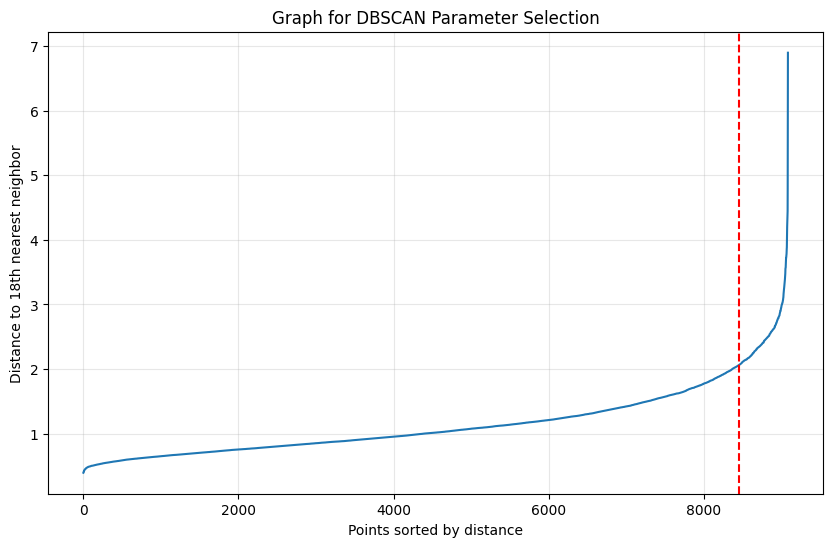

In [60]:
n_features = X.shape[1]
k = 2 * n_features

nn = NearestNeighbors(n_neighbors=k)
nn.fit(X)

distances, indices = nn.kneighbors(X.values)
k_distances = distances[:, k - 1]
k_distances_sorted = np.sort(k_distances)

x = 8450

plt.figure(figsize=(10, 6))
plt.plot(k_distances_sorted)
plt.xlabel("Points sorted by distance")
plt.ylabel(f"Distance to {k}th nearest neighbor")
plt.title("Graph for DBSCAN Parameter Selection")
plt.grid(True, alpha=0.3)
plt.axvline(x=x, color="r", linestyle="--")
plt.show()

epsilon = k_distances_sorted[x]

Wykres nie pokazuje wyraźnego punktu przegięcia - krzywa rośnie stopniowo bez ostrego "łokcia". Dokładne wyznaczenie epsilon jest bardzo trudne, bo przejście jest płynne. Epsilon został wybrany "na oko".

Taka heurystyczna metoda jest wykorzystywana w wielu przypadkach doboru hiperparametrów w klasteryzacji. Zasadnicza idea jest taka, że punkt przegięcia odpowiada momentowi, gdzie dane zaczynają wyraźnie rozróżniać się od siebie i tworzyć wyraźne grupy. Jest to proste i szybkie, ale jest dość nieprecyzyjne w porównaniu do innych metod (jeżeli w ogóle istnieją dla danego zadania!). Jeżeli chcemy zrobić walidację skrośną, korzystając z jakiejś metryki, to taki wykres daje nam sensowny punkt wyjścia do zakresu hiperparametru.

Warto też pamiętać, że klasteryzacja to proces z natury interaktywny. Takie wykresy są ważne, bo zwiększają naszą intuicję, ale np. dokładne dobranie wartości jest typowo robione ręcznie.

**Zadanie 5 (1.5 punktu)**

Wytrenuj DBSCAN z promieniem epsilon wyznaczonym z wykresu i min_samples równym 2 razy liczbie cech. W razie potrzeby zmniejsz lub zwiększ epsilon, aby uzyskać wyniki, które wydają się sensowne (liczba klastrów, procent szumu, CH-index).

Dokonaj analizy wyjściowych klastrów. Czy finalna ich liczba oraz procent szumu są sensowne? Czy klastry są lepiej widoczne, lub lepiej interpretowalne, niż w przypadku k-means?

Number of clusters: 4
Percentage of noise points: 1.95%
CH-index value: 1102.46


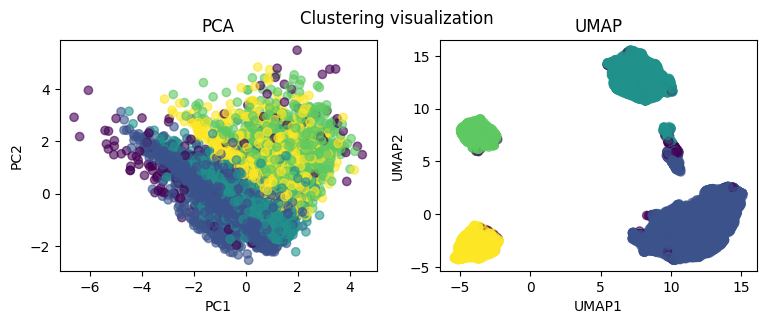

Cluster 0 size: 4518


,Track,Artist
0,Penny Lane - Remastered 2009,The Beatles
1,Lay It All on Me (feat. Ed Sheeran),Rudimental
2,Rather Be (feat. Jess Glynne),Clean Bandit
3,I'd Rather,Luther Vandross
4,Harness Your Hopes - B-side,Pavement
5,Don't Panic,Coldplay
6,Anyone,Justin Bieber
7,Woke up in Bangkok,Deepend
8,Cheerleader - Felix Jaehn Remix Radio Edit,OMI
9,Strangers Like Me,Phil Collins


Top 10 genres in the cluster: ['pop', 'rock', 'dance pop', 'post-teen pop', 'classic rock', 'mellow gold', 'pop rock', 'soft rock', 'modern rock', 'album rock']
Cluster 1 size: 2205


,Track,Artist
0,Until The End Of Time (with Beyoncé),Justin Timberlake
1,OK,Robin Schulz
2,React,The Pussycat Dolls
3,Message Man,Twenty One Pilots
4,Greek Tragedy - Oliver Nelson TikTok Remix,The Wombats
5,Going Dumb (with Stray Kids),Alesso
6,Look What You Made Me Do,Taylor Swift
7,Closer,Ne-Yo
8,One More Time (feat. Alida) - Quarterhead Remix,Robin Schulz
9,head first,Christian French


Top 10 genres in the cluster: ['pop', 'dance pop', 'rock', 'post-teen pop', 'pop dance', 'edm', 'modern rock', 'tropical house', 'classic rock', 'pop rap']
Cluster 3 size: 1202


,Track,Artist
0,Broken Clocks,SZA
1,just like magic,Ariana Grande
2,These Walls,Kendrick Lamar
3,All Night (feat. Knox Fortune),Chance the Rapper
4,Paramedic!,SOB X RBE
5,Luxury,Azealia Banks
6,Guerrilla Radio,Rage Against The Machine
7,Tia Tamera (feat. Rico Nasty),Doja Cat
8,Lost,Frank Ocean
9,Prospect (ft. Lil Baby),iann dior


Top 10 genres in the cluster: ['rap', 'hip hop', 'pop rap', 'pop', 'trap', 'dance pop', 'southern hip hop', 'gangster rap', 'post-teen pop', 'r&b']
Cluster 2 size: 985


,Track,Artist
0,"A$AP Forever REMIX (feat. Moby, T.I. & Kid Cudi)",A$AP Rocky
1,A$AP Forever (feat. Moby),A$AP Rocky
2,beibs in the trap,Travis Scott
3,Why Do You Lie To Me (feat. Lil Baby),Topic
4,Like That (feat. Gucci Mane),Doja Cat
5,Bodak Yellow,Cardi B
6,Shake That,Eminem
7,Here I Am,Rick Ross
8,Stranger Things,Joyner Lucas
9,All Day,Kanye West


Top 10 genres in the cluster: ['rap', 'hip hop', 'pop rap', 'trap', 'pop', 'dance pop', 'southern hip hop', 'gangster rap', 'r&b', 'melodic rap']


In [61]:
clustering = DBSCAN(min_samples=k, eps=epsilon, n_jobs=-1)
clustering.fit(X)

dbscan_analyzer.analyze_clustering(X, clustering)

Wyniki wyglądają nieco lepiej, jednak wciąż nie są idealne, a samych klastrów, w przypadku podziału muzyki, wydaje się byćbardzo mało.

DBSCAN ma dwie zasadnicze wady: trudny dobór hiperparametrów oraz podatność na szum. W szczególności to drugie widać, jeżeli w naszym zbiorze ciągle znajduje on dużo szumu - to oznaka, że mamy zmienną gęstość w danych i przydałoby się coś adaptacyjnego, jak OPTICS albo HDBSCAN. OPTICS jest bardziej zoptymalizowany pod pamięć niż szybkość w scikit-learn, plus ma raczej nieintuicyjne hiperparametry (może nawet bardziej, niż DBSCAN), więc wykorzystamy tutaj HDBSCAN.

Jego głównym hiperparametrem jest `min_cluster_size`, czyli po prostu minimalna liczba punktów, aby stworzyć klaster. Dodatkowo `min_samples` ma takie samo znaczenie, jak w DBSCAN, czyli jest to minimalna liczba punktów, aby utworzyć punkt typu CORE. Domyślnie są one równe, ale oczywiście można ustawić `min_samples` (sporo) mniejsze od `min_cluster_size`, i dostrajać oba.

Number of clusters: 7
Percentage of noise points: 3.71%
CH-index value: 615.80


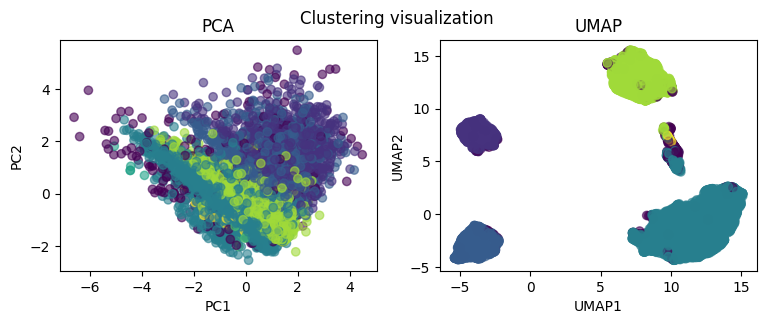

Cluster 2 size: 4473


,Track,Artist
0,All I Have to Do Is Dream,The Everly Brothers
1,All Day and All of the Night,The Kinks
2,The Times They Are A-Changin',Bob Dylan
3,Missing You,The Vamps
4,7UP,Boy In Space
5,Fix It to Break It,Clinton Kane
6,Lotus Inn,Why Don't We
7,remember the mornings,Clinton Kane
8,blind,ROLE MODEL
9,Only the Lonely,Roy Orbison


Top 10 genres in the cluster: ['pop', 'rock', 'dance pop', 'post-teen pop', 'classic rock', 'pop rock', 'mellow gold', 'soft rock', 'modern rock', 'album rock']
Cluster 5 size: 2061


,Track,Artist
0,I Get Around (Mono),The Beach Boys
1,The Sky Is A Neighborhood,Foo Fighters
2,And I Love Her - Remastered 2009,The Beatles
3,Friend Of Mine (feat. Vargas & Lagola),Avicii
4,Heart Upon My Sleeve (feat. Imagine Dragons),Avicii
5,Fingers Crossed,Agnes
6,Going Dumb,Alesso
7,Talk,Why Don't We
8,What They'll Say About Us,FINNEAS
9,Breaking Up Is Hard to Do,Neil Sedaka


Top 10 genres in the cluster: ['pop', 'dance pop', 'rock', 'post-teen pop', 'pop dance', 'modern rock', 'edm', 'tropical house', 'classic rock', 'pop rap']
Cluster 1 size: 1197


,Track,Artist
0,Ain't No Fun (If the Homies Cant Have None) (f...,Snoop Dogg
1,dead girl in the pool.,girl in red
2,in my head,Ariana Grande
3,happiness,Taylor Swift
4,just like magic,Ariana Grande
5,Boyz-N-The-Hood - Remix,Eazy-E
6,peace,Taylor Swift
7,anxiety (with FRND),blackbear
8,No More ?'s,Eazy-E
9,It's So Easy,Guns N' Roses


Top 10 genres in the cluster: ['rap', 'hip hop', 'pop rap', 'pop', 'trap', 'dance pop', 'southern hip hop', 'gangster rap', 'post-teen pop', 'r&b']
Cluster 0 size: 987


,Track,Artist
0,On My Own,Jaden
1,Wild Child,W.A.S.P.
2,This Life,Denzel Curry
3,Different,Hippie Sabotage
4,A$AP Forever (feat. Moby),A$AP Rocky
5,"A$AP Forever REMIX (feat. Moby, T.I. & Kid Cudi)",A$AP Rocky
6,shining on my ex,bbno$
7,Hope You Do,Chris Brown
8,The Break Up,Machine Gun Kelly
9,I Wanna Be Somebody,W.A.S.P.


Top 10 genres in the cluster: ['rap', 'hip hop', 'pop rap', 'trap', 'pop', 'dance pop', 'southern hip hop', 'gangster rap', 'r&b', 'melodic rap']


In [62]:
clustering = HDBSCAN()
clustering.fit(X)

dbscan_analyzer = HDBSCANAnalyzer(df_songs_info, clustering_visualizer)
dbscan_analyzer.analyze_clustering(X, clustering)

Domyślne `min_cluster_size` to zaledwie 5, a mimo tego HDBSCAN wcale nie znalazł tak dużo klastrów - pokazuje to jego zdolność do adaptacji do zbioru danych. CH-index nie jest zbyt wysoki, pomimo tego, że niektóre klastry wydają się ciekawe i inne niż w k-means. Pokazuje to też, że klastry pewnie nie są sferyczne.

**Zadanie 6 (2 punkty)**

Dokonaj ręcznego tuningu hiperparametrów `min_cluster_size` oraz `min_samples`. Pamiętaj, że przy stałym `min_samples` możesz praktycznie za darmo zmieniać `min_cluster_size` dzięki cache'owaniu.

Skomentuj finalne wyniki. Czy udało się uzyskać sensowne, interpretowalne klastry? Czy są one w jakimś stopniu nieoczywiste, tj. czy otrzymaliśmy jakąś nową wiedzę dzięki klasteryzacji? Czy CH-index wskazał sensownie na jakość klasteryzacji w HDBSCAN?

Number of clusters: 4
Percentage of noise points: 4.02%
CH-index value: 1126.32


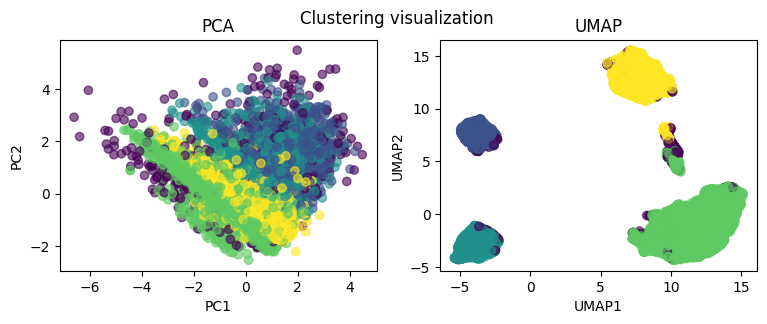

Cluster 2 size: 4473


,Track,Artist
0,Be My Escape,Relient K
1,Pocket Full Of Gold,American Authors
2,You And I,LÉON
3,Bad At Love,Halsey
4,"Let Me Go (with Alesso, Florida Georgia Line &...",Hailee Steinfeld
5,Just Imagine It,MKTO
6,Father Of Mine,Everclear
7,Body,Loud Luxury
8,There She Goes,Sixpence None The Richer
9,Back In Time,Huey Lewis & The News


Top 10 genres in the cluster: ['pop', 'rock', 'dance pop', 'post-teen pop', 'classic rock', 'mellow gold', 'pop rock', 'soft rock', 'modern rock', 'album rock']
Cluster 3 size: 2135


,Track,Artist
0,Fell On Black Days,Soundgarden
1,Outshined,Soundgarden
2,Come As You Are,Nirvana
3,Love Bites - Remastered 2017,Def Leppard
4,Flashdance...What a Feeling - Radio Edit,Irene Cara
5,Refugee,Tom Petty and the Heartbreakers
6,Sad Child,Sandro Cavazza
7,Bombay Dreams (feat. Kavita Seth),KSHMR
8,Obsessed,Dynoro
9,Because the Night,Patti Smith


Top 10 genres in the cluster: ['pop', 'dance pop', 'rock', 'post-teen pop', 'pop dance', 'edm', 'modern rock', 'tropical house', 'classic rock', 'pop rap']
Cluster 1 size: 1171


,Track,Artist
0,Woo Hah!! Got You All in Check,Busta Rhymes
1,ball w/o you,21 Savage
2,Pray For Me (with Kendrick Lamar),The Weeknd
3,Rich & Sad,Post Malone
4,Wasabi,Little Mix
5,breathin,Ariana Grande
6,UCLA,RL Grime
7,Ain't No Fun (If the Homies Cant Have None) (f...,Snoop Dogg
8,Swervin (feat. Veysel),A Boogie Wit da Hoodie
9,in my head,Ariana Grande


Top 10 genres in the cluster: ['rap', 'hip hop', 'pop rap', 'pop', 'trap', 'dance pop', 'southern hip hop', 'gangster rap', 'post-teen pop', 'r&b']
Cluster 0 size: 943


,Track,Artist
0,Express Yourself - Remix,N.W.A.
1,If I Ruled the World (Imagine That) (feat. Lau...,Nas
2,Heaven Beside You,Alice In Chains
3,A$AP Forever (feat. Moby),A$AP Rocky
4,Mouth for War,Pantera
5,Retro (Rough),Childish Gambino
6,Hope You Do,Chris Brown
7,The Break Up,Machine Gun Kelly
8,Wild Child,W.A.S.P.
9,No I in Team,Arizona Zervas


Top 10 genres in the cluster: ['rap', 'hip hop', 'pop rap', 'trap', 'pop', 'dance pop', 'southern hip hop', 'gangster rap', 'r&b', 'melodic rap']


In [64]:
clustering = HDBSCAN(min_cluster_size=200, min_samples=10, n_jobs=-1)
clustering.fit(X)

dbscan_analyzer.analyze_clustering(X, clustering)

Osiągnięte klastry są podobne do tych osiągniętych w DBSCAN. Podobieństwo wyników HDBSCAN i DBSCAN może wynikać z tego, że oba są algorytmami gęstościowymi - przy zbliżonych parametrach dają podobne rezultaty. Klasteryzacja ujawniła dość sensowną strukturę: duży klaster na najpopularniejsze gatunki (pop), kilka mniejszych dla innych popularnych gatunków muzycznych. Ciężko powiedzieć, z czego wynika mieszanie się niektórych odległych klastrów.

## Zadanie dodatkowe (3 punkty)

Klasteryzacja hierarchiczna jest przydatnym narzędziem, dającym od razu znaczną ilość informacji co do klasteryzacji, ale ze względu na złożoność nadaje się tylko do mniejszych zbiorów danych. Takim zbiorem jest dobrze nam już znany [Ames housing](https://www.openintro.org/book/statdata/?data=ames).

1. Załaduj zbiór i dokonaj odpowiedniego preprocessingu. Zwizualizuj go z pomocą PCA oraz UMAP.
2. Zastosuj klasteryzację hierarchiczną do tego zbioru, wykorzystując metrykę euklidesową i Ward linkage.
3. Narysuj dendrogram dla wynikowej klasteryzacji. Czy widać jakąś strukturę klastrującą? Sprawdź kilka przykładowych próbek, które wydają się podobne - czy faktycznie te domy są podobne?
4. Wybierz klasteryzację, która wydaje się najbardziej stabilna, tj. ma najdłuższe pionowe linie na dendrogramie. Sprawdź jej CH-index, oraz zwizualizuj ją za pomocą PCA oraz UMAP. Ile ma ona klastrów? Czy wydaje się ona sensowna? Wypisz przykładowe domy z klastrów. Czy faktycznie wskazują na zróżnicowanie klastrów?
5. Porównaj tę klasteryzację z k-means (dokonaj tuningu liczby klastrów z pomocą CH-index) oraz HDBSCAN. Ile klastrów wybrały te metody? Czy na wizualizacji PCA i UMAP dają lepsze, czy gorsze wyniki od klasteryzacji hierarchicznej?

In [70]:
df = pd.read_parquet("../../../Users/micha/Downloads/ames_data.parquet")
df.head()

# remove dots from names to match data_description.txt
df.columns = [col.replace(".", "") for col in df.columns]

df = df.drop(["Order", "PID"], axis="columns")
df = df.loc[~df["Neighborhood"].isin(["GrnHill", "Landmrk"]), :]

# df = df.loc[df["GrLivArea"] <= 4000, :]

# Normalize data, use np.log1p
df["SalePrice"] = np.log1p(df["SalePrice"])


def replace_na(df: pd.DataFrame, col: str, value) -> None:
    df.loc[:, col] = df.loc[:, col].fillna(value)


# Alley : data description says NA means "no alley access"
replace_na(df, "Alley", value="None")

# BedroomAbvGr : NA most likely means 0
replace_na(df, "BedroomAbvGr", value=0)

# BsmtQual etc : data description says NA for basement features is "no basement"
replace_na(df, "BsmtQual", value="No")
replace_na(df, "BsmtCond", value="No")
replace_na(df, "BsmtExposure", value="No")
replace_na(df, "BsmtFinType1", value="No")
replace_na(df, "BsmtFinType2", value="No")
replace_na(df, "BsmtFullBath", value=0)
replace_na(df, "BsmtHalfBath", value=0)
replace_na(df, "BsmtUnfSF", value=0)

# Condition : NA most likely means Normal
replace_na(df, "Condition1", value="Norm")
replace_na(df, "Condition2", value="Norm")

# External stuff : NA most likely means average
replace_na(df, "ExterCond", value="TA")
replace_na(df, "ExterQual", value="TA")

# Fence : data description says NA means "no fence"
replace_na(df, "Fence", value="No")

# Functional : data description says NA means typical
replace_na(df, "Functional", value="Typ")

# GarageType etc : data description says NA for garage features is "no garage"
replace_na(df, "GarageType", value="No")
replace_na(df, "GarageFinish", value="No")
replace_na(df, "GarageQual", value="No")
replace_na(df, "GarageCond", value="No")
replace_na(df, "GarageArea", value=0)
replace_na(df, "GarageCars", value=0)

# HalfBath : NA most likely means no half baths above grade
replace_na(df, "HalfBath", value=0)

# HeatingQC : NA most likely means typical
replace_na(df, "HeatingQC", value="Ta")

# KitchenAbvGr : NA most likely means 0
replace_na(df, "KitchenAbvGr", value=0)

# KitchenQual : NA most likely means typical
replace_na(df, "KitchenQual", value="TA")

# LotFrontage : NA most likely means no lot frontage
replace_na(df, "LotFrontage", value=0)

# LotShape : NA most likely means regular
replace_na(df, "LotShape", value="Reg")

# MasVnrType : NA most likely means no veneer
replace_na(df, "MasVnrType", value="None")
replace_na(df, "MasVnrArea", value=0)

# MiscFeature : data description says NA means "no misc feature"
replace_na(df, "MiscFeature", value="No")
replace_na(df, "MiscVal", value=0)

# OpenPorchSF : NA most likely means no open porch
replace_na(df, "OpenPorchSF", value=0)

# PavedDrive : NA most likely means not paved
replace_na(df, "PavedDrive", value="N")

# PoolQC : data description says NA means "no pool"
replace_na(df, "PoolQC", value="No")
replace_na(df, "PoolArea", value=0)

# SaleCondition : NA most likely means normal sale
replace_na(df, "SaleCondition", value="Normal")

# ScreenPorch : NA most likely means no screen porch
replace_na(df, "ScreenPorch", value=0)

# TotRmsAbvGrd : NA most likely means 0
replace_na(df, "TotRmsAbvGrd", value=0)

# Utilities : NA most likely means all public utilities
replace_na(df, "Utilities", value="AllPub")

# WoodDeckSF : NA most likely means no wood deck
replace_na(df, "WoodDeckSF", value=0)

# CentralAir : NA most likely means No
replace_na(df, "CentralAir", value="N")

# EnclosedPorch : NA most likely means no enclosed porch
replace_na(df, "EnclosedPorch", value=0)

# FireplaceQu : data description says NA means "no fireplace"
replace_na(df, "FireplaceQu", value="No")
replace_na(df, "Fireplaces", value=0)

# SaleCondition : NA most likely means normal sale
replace_na(df, "SaleCondition", value="Normal")

# Electrical : NA most likely means standard circuit & breakers
replace_na(df, "Electrical", value="SBrkr")

df = df.replace(
    {
        "MSSubClass": {
            20: "SC20",
            30: "SC30",
            40: "SC40",
            45: "SC45",
            50: "SC50",
            60: "SC60",
            70: "SC70",
            75: "SC75",
            80: "SC80",
            85: "SC85",
            90: "SC90",
            120: "SC120",
            150: "SC150",
            160: "SC160",
            180: "SC180",
            190: "SC190",
        },
        "MoSold": {
            1: "Jan",
            2: "Feb",
            3: "Mar",
            4: "Apr",
            5: "May",
            6: "Jun",
            7: "Jul",
            8: "Aug",
            9: "Sep",
            10: "Oct",
            11: "Nov",
            12: "Dec",
        },
    }
)

df = df.replace(
    {
        "Alley": {"None": 0, "Grvl": 1, "Pave": 2},
        "BsmtCond": {"No": 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5},
        "BsmtExposure": {"No": 0, "Mn": 1, "Av": 2, "Gd": 3},
        "BsmtFinType1": {
            "No": 0,
            "Unf": 1,
            "LwQ": 2,
            "Rec": 3,
            "BLQ": 4,
            "ALQ": 5,
            "GLQ": 6,
        },
        "BsmtFinType2": {
            "No": 0,
            "Unf": 1,
            "LwQ": 2,
            "Rec": 3,
            "BLQ": 4,
            "ALQ": 5,
            "GLQ": 6,
        },
        "BsmtQual": {"No": 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5},
        "ExterCond": {"Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5},
        "ExterQual": {"Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5},
        "FireplaceQu": {"No": 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5},
        "Functional": {
            "Sal": 1,
            "Sev": 2,
            "Maj2": 3,
            "Maj1": 4,
            "Mod": 5,
            "Min2": 6,
            "Min1": 7,
            "Typ": 8,
        },
        "GarageCond": {"No": 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5},
        "GarageQual": {"No": 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5},
        "HeatingQC": {"Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5},
        "KitchenQual": {"Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5},
        "LandSlope": {"Sev": 1, "Mod": 2, "Gtl": 3},
        "LotShape": {"IR3": 1, "IR2": 2, "IR1": 3, "Reg": 4},
        "PavedDrive": {"N": 0, "P": 1, "Y": 2},
        "PoolQC": {"No": 0, "Fa": 1, "TA": 2, "Gd": 3, "Ex": 4},
        "Street": {"Grvl": 1, "Pave": 2},
        "Utilities": {"ELO": 1, "NoSeWa": 2, "NoSewr": 3, "AllPub": 4},
    }
)

y = df.pop("SalePrice")

<ipython-input-70-1613939519>:160: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



In [75]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

X = df.select_dtypes(exclude="object")

pipeline = make_pipeline(SimpleImputer(strategy="median"), StandardScaler())
X_scaled = pipeline.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



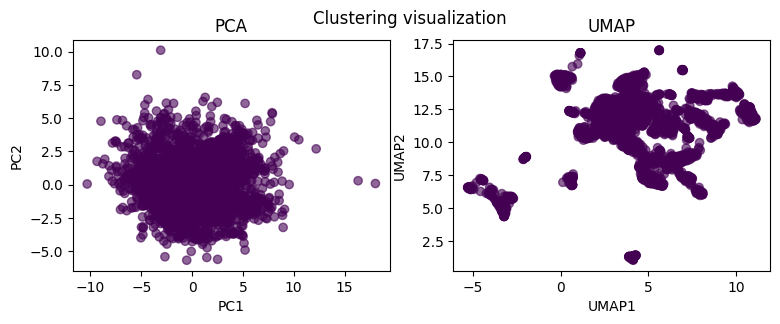

In [81]:
visualizer = ClusteringVisualizer(X_scaled)
visualizer.visualize()

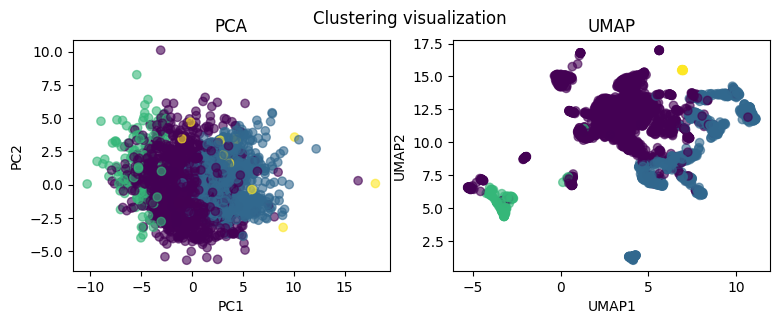

In [83]:
from sklearn.cluster import AgglomerativeClustering

clustering = AgglomerativeClustering(
    linkage="ward",
    metric="euclidean",
    n_clusters=None,
    distance_threshold=100,
)
clustering.fit(X_scaled)
visualizer.visualize(clustering.labels_)

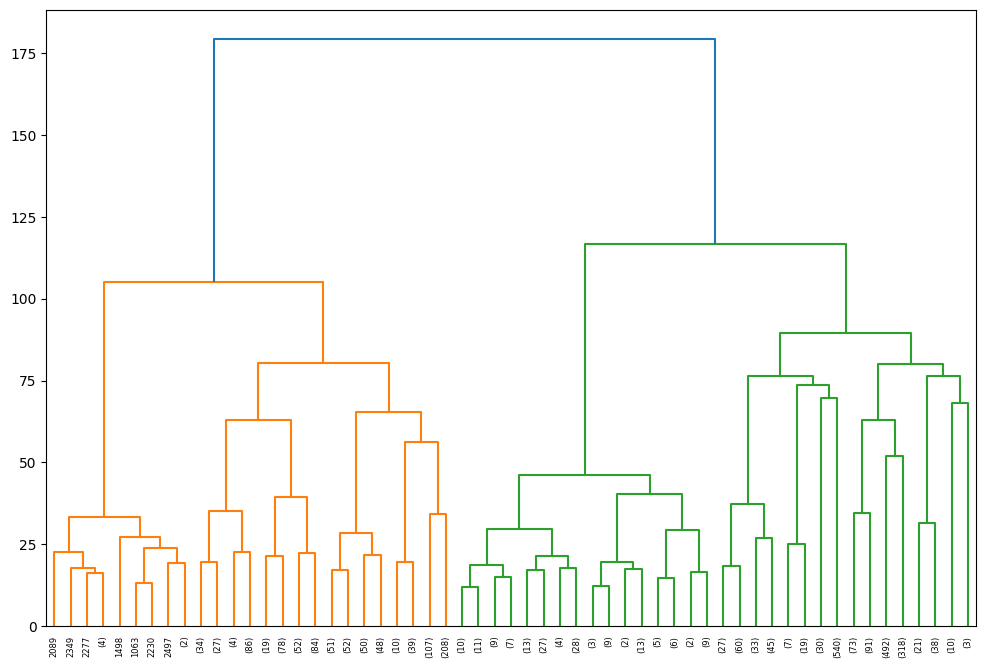

In [84]:
from scipy.cluster.hierarchy import dendrogram


def plot_dendrogram(model, **kwargs):
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)

    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    plt.figure(figsize=kwargs.get("figsize", (12, 8)))
    dendrogram(linkage_matrix, **kwargs)


plot_dendrogram(clustering, truncate_mode="level", p=5)